In [1]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("../data/processed/dataset_processed.csv")

In [4]:
X = df.iloc[:, :51].drop(columns=['file_path'])
Y = df.iloc[:, 51:]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

In [5]:
param_distributions = {
    "estimator__max_depth": [3, 5, 7, 9],
    "estimator__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "estimator__max_iter": [100, 200, 400],
    "estimator__min_samples_leaf": [10, 20, 50],
    "estimator__l2_regularization": [0.0, 0.1, 1.0]
}

base_model = HistGradientBoostingClassifier(
    random_state=42
)

model = MultiOutputClassifier(base_model)

In [6]:
scorer = make_scorer(f1_score, average="micro")

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=25,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, Y_train)
best_model = search.best_estimator_
best_params = search.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [7]:
print("Best CV micro-F1:", search.best_score_)
print("Average CV micro-F1:", search.cv_results_['mean_test_score'].mean())
print("Best parameters:", best_params)

Best CV micro-F1: 0.9866433300728232
Average CV micro-F1: 0.982153408892665
Best parameters: {'estimator__min_samples_leaf': 10, 'estimator__max_iter': 200, 'estimator__max_depth': 9, 'estimator__learning_rate': 0.1, 'estimator__l2_regularization': 1.0}


In [8]:
Y_pred = best_model.predict(X_test)

print("Test micro-F1:", f1_score(Y_test, Y_pred, average="micro"))

print(classification_report(Y_test, Y_pred, target_names=Y.columns))


Test micro-F1: 0.9841907824222936
                      precision    recall  f1-score   support

       y_FeatureEnvy       0.99      0.99      0.99       320
  y_FormattingIssues       0.90      0.88      0.89       368
  y_GlobalStateAbuse       1.00      1.00      1.00        49
          y_GodClass       0.87      0.82      0.85        40
y_LargeParameterList       1.00      1.00      1.00       520
         y_LazyClass       1.00      0.99      1.00       137
        y_LongMethod       1.00      1.00      1.00       215
y_MisleadingComments       1.00      1.00      1.00       327
 y_PoorDocumentation       1.00      1.00      1.00       587
     y_SpaghettiCode       1.00      0.81      0.89        31
    y_UnstableModule       1.00      0.95      0.97        20
      y_UntestedCode       1.00      1.00      1.00       319
         y_any_smell       0.98      1.00      0.99       803

           micro avg       0.99      0.98      0.98      3736
           macro avg       0.98   

In [9]:
param_grid = {
    "estimator__max_depth": [
        best_params["estimator__max_depth"] - 1,
        best_params["estimator__max_depth"],
        best_params["estimator__max_depth"] + 1,
    ],
    "estimator__learning_rate": [
        best_params["estimator__learning_rate"] * 0.7,
        best_params["estimator__learning_rate"],
        best_params["estimator__learning_rate"] * 1.3,
    ],
    "estimator__min_samples_leaf": [
        max(5, best_params["estimator__min_samples_leaf"] - 5),
        best_params["estimator__min_samples_leaf"],
        best_params["estimator__min_samples_leaf"] + 5,
    ],
}

In [10]:
grid_search = GridSearchCV(
    estimator=best_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, Y_train)
final_model = grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [11]:
print("Refined CV micro-F1:", grid_search.best_score_)
print("Refined best parameters:", grid_search.best_params_)

Refined CV micro-F1: 0.9868115019065647
Refined best parameters: {'estimator__learning_rate': 0.13, 'estimator__max_depth': 10, 'estimator__min_samples_leaf': 10}


In [12]:
Y_pred = final_model.predict(X_test)

print("Test micro-F1:",
      f1_score(Y_test, Y_pred, average="micro"))

print(classification_report(Y_test, Y_pred, target_names=Y.columns))

Test micro-F1: 0.984050395389358
                      precision    recall  f1-score   support

       y_FeatureEnvy       0.99      0.99      0.99       320
  y_FormattingIssues       0.90      0.87      0.89       368
  y_GlobalStateAbuse       1.00      1.00      1.00        49
          y_GodClass       0.87      0.82      0.85        40
y_LargeParameterList       1.00      1.00      1.00       520
         y_LazyClass       1.00      0.99      1.00       137
        y_LongMethod       1.00      1.00      1.00       215
y_MisleadingComments       1.00      1.00      1.00       327
 y_PoorDocumentation       1.00      1.00      1.00       587
     y_SpaghettiCode       1.00      0.81      0.89        31
    y_UnstableModule       1.00      0.95      0.97        20
      y_UntestedCode       1.00      1.00      1.00       319
         y_any_smell       0.98      1.00      0.99       803

           micro avg       0.99      0.98      0.98      3736
           macro avg       0.98    

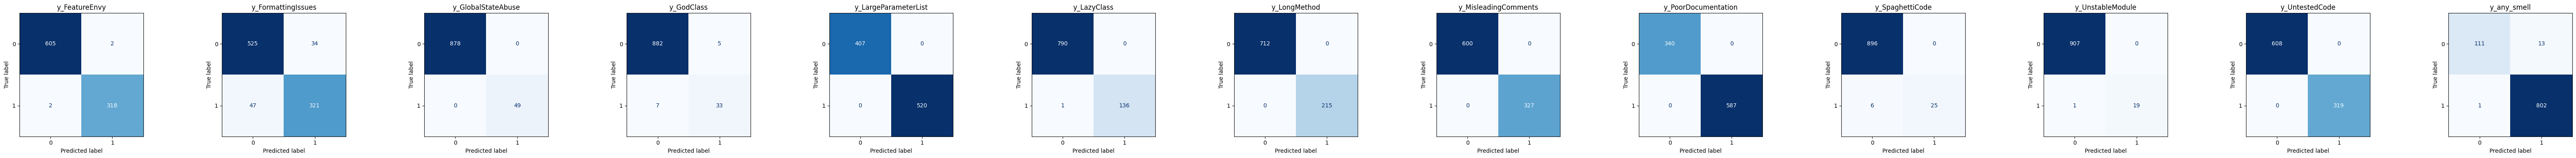

In [13]:
# Confusion Matrix Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(1, len(Y.columns), figsize=(5 * len(Y.columns), 4))
if len(Y.columns) == 1:
    axes = [axes]

for i, col in enumerate(Y.columns):
    cm = confusion_matrix(Y_test[col], Y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
    disp.plot(ax=axes[i], cmap="Blues", colorbar=False)
    axes[i].set_title(col)

plt.tight_layout()
plt.savefig("../models/histogram_gb_confusion_matrix.png", dpi=150)
plt.show()

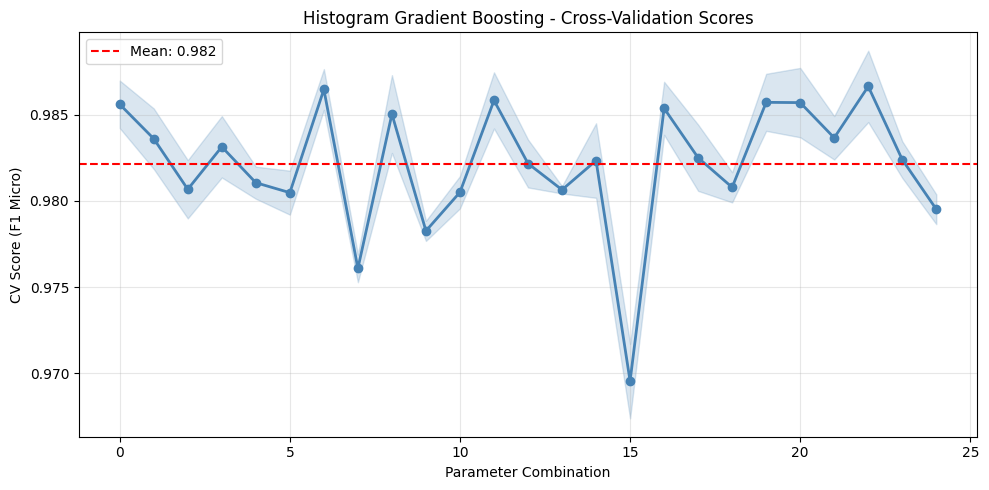

In [14]:
# Cross-Validation Scores Visualization
import numpy as np

cv_scores = search.cv_results_["mean_test_score"]
cv_std = search.cv_results_["std_test_score"]

plt.figure(figsize=(10, 5))
x = np.arange(len(cv_scores))
plt.plot(x, cv_scores, marker="o", color="steelblue", linewidth=2, markersize=6)
plt.fill_between(x, cv_scores - cv_std, cv_scores + cv_std, alpha=0.2, color="steelblue")
plt.axhline(y=cv_scores.mean(), color="red", linestyle="--", label=f"Mean: {cv_scores.mean():.3f}")
plt.xlabel("Parameter Combination")
plt.ylabel("CV Score (F1 Micro)")
plt.title("Histogram Gradient Boosting - Cross-Validation Scores")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../models/histogram_gb_cv_scores.png", dpi=150)
plt.show()

In [15]:
with open('../models/histogram_gb.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("Histogram Gradient Boosting model saved.")

Histogram Gradient Boosting model saved.
